In [1]:
#add here your imports
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
import seaborn as sns

In [2]:
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error , accuracy_score , mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

In [3]:
# load data
PATH_TO_DATA = os.path.join("..","data","dow_jones_index.data")
data_original = pd.read_csv(PATH_TO_DATA)
data = data_original
#add here your data understanting code


In [4]:
# converting money variables to floats
money_variables = ['open','high','low','close','next_weeks_open','next_weeks_close']

for v in money_variables:
    data[v]=data[v].str[1:].astype(float)
    
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data['stock']= data['stock'].astype('category')

In [5]:
# Dealing with target leakage

# We do not include "next_weeks_open" as when we decide to buy we can see the current price of the stocks.
# Since we are not told when the decision must be made I am assuming it is made as soon as the next week starts
future_columns = ["next_weeks_close","percent_change_next_weeks_price", "percent_return_next_dividend"]

Y = data[["stock","next_weeks_close"]]
change_gt = data[["stock","percent_change_next_weeks_price"]]
data= data.drop(columns=future_columns)

In [6]:
data.dtypes

quarter                                  int64
stock                                 category
open                                   float64
high                                   float64
low                                    float64
close                                  float64
volume                                   int64
percent_change_price                   float64
percent_change_volume_over_last_wk     float64
previous_weeks_volume                  float64
next_weeks_open                        float64
days_to_next_dividend                    int64
dtype: object

In [7]:
data.isna().sum()

quarter                                0
stock                                  0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
days_to_next_dividend                  0
dtype: int64

In [8]:
# fill NAN values with zero
data[['percent_change_volume_over_last_wk','previous_weeks_volume']] =data[['percent_change_volume_over_last_wk','previous_weeks_volume']].fillna(0)

In [9]:
data.head()

quarter stock   open   high    low  close     volume  \
date                                                               
2011-01-07        1    AA  15.82  16.72  15.78  16.42  239655616   
2011-01-14        1    AA  16.71  16.71  15.64  15.97  242963398   
2011-01-21        1    AA  16.19  16.38  15.60  15.79  138428495   
2011-01-28        1    AA  15.87  16.63  15.82  16.13  151379173   
2011-02-04        1    AA  16.18  17.39  16.18  17.14  154387761   

            percent_change_price  percent_change_volume_over_last_wk  \
date                                                                   
2011-01-07               3.79267                            0.000000   
2011-01-14              -4.42849                            1.380223   
2011-01-21              -2.47066                          -43.024959   
2011-01-28               1.63831                            9.355500   
2011-02-04               5.93325                            1.987452   

            previous_weeks_volume  next_weeks_open  days_to_next_dividend  
date                                                                       
2011-01-07                    0.0            16.71                     26  
2011-01-14            239655616.0            16.19                     19  
2011-01-21            242963398.0            15.87                     12  
2011-01-28            138428495.0            16.18                      5  
2011-02-04            151379173.0            17.33                     97

In [10]:
data.tail()

quarter stock   open   high    low  close     volume  \
date                                                               
2011-05-27        2   XOM  80.22  82.63  80.07  82.63   68230855   
2011-06-03        2   XOM  83.28  83.75  80.18  81.18   78616295   
2011-06-10        2   XOM  80.93  81.87  79.72  79.78   92380844   
2011-06-17        2   XOM  80.00  80.82  78.33  79.02  100521400   
2011-06-24        2   XOM  78.65  81.12  76.78  76.78  118679791   

            percent_change_price  percent_change_volume_over_last_wk  \
date                                                                   
2011-05-27               3.00424                          -21.355713   
2011-06-03              -2.52161                           15.221032   
2011-06-10              -1.42098                           17.508519   
2011-06-17              -1.22500                            8.811952   
2011-06-24              -2.37762                           18.064204   

            previous_weeks_volume  next_weeks_open  days_to_next_dividend  
date                                                                       
2011-05-27             86758820.0            83.28                     75  
2011-06-03             68230855.0            80.93                     68  
2011-06-10             78616295.0            80.00                     61  
2011-06-17             92380844.0            78.65                     54  
2011-06-24            100521400.0            76.88                     47

In [11]:
data.describe(include='all')

quarter stock        open        high         low       close  \
count   750.000000   750  750.000000  750.000000  750.000000  750.000000   
unique         NaN    30         NaN         NaN         NaN         NaN   
top            NaN   XOM         NaN         NaN         NaN         NaN   
freq           NaN    25         NaN         NaN         NaN         NaN   
mean      1.520000   NaN   53.651840   54.669987   52.640160   53.729267   
std       0.499933   NaN   32.638852   33.215994   32.119277   32.788787   
min       1.000000   NaN   10.590000   10.940000   10.400000   10.520000   
25%       1.000000   NaN   29.830000   30.627500   28.720000   30.365000   
50%       2.000000   NaN   45.970000   46.885000   44.800000   45.930000   
75%       2.000000   NaN   72.715000   74.287500   71.037500   72.667500   
max       2.000000   NaN  172.110000  173.540000  167.820000  170.580000   

              volume  percent_change_price  \
count   7.500000e+02            750.000000   
unique           NaN                   NaN   
top              NaN                   NaN   
freq             NaN                   NaN   
mean    1.175478e+08              0.050262   
std     1.584381e+08              2.517809   
min     9.718851e+06            -15.422900   
25%     3.086624e+07             -1.288053   
50%     5.306088e+07              0.000000   
75%     1.327218e+08              1.650888   
max     1.453439e+09              9.882230   

        percent_change_volume_over_last_wk  previous_weeks_volume  \
count                           750.000000           7.500000e+02   
unique                                 NaN                    NaN   
top                                    NaN                    NaN   
freq                                   NaN                    NaN   
mean                              5.369881           1.126921e+08   
std                              39.738369           1.576997e+08   
min                             -61.433175           0.000000e+00   
25%                             -18.890959           2.812398e+07   
50%                               0.000000           5.069022e+07   
75%                              19.984489           1.296170e+08   
max                             327.408924           1.453439e+09   

        next_weeks_open  days_to_next_dividend  
count        750.000000             750.000000  
unique              NaN                    NaN  
top                 NaN                    NaN  
freq                NaN                    NaN  
mean          53.702440              52.525333  
std           32.778111              46.335098  
min           10.520000               0.000000  
25%           30.315000              24.000000  
50%           46.015000              47.000000  
75%           72.715000              69.000000  
max          172.110000             336.000000

In [12]:
numeric_features = data.select_dtypes(include=np.number).columns.tolist()
categorical_features = data.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())])# normalize data

#categorical_transformer = Pipeline(())

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)], remainder='passthrough')

In [13]:
# divide data by company

data_by_stock = {}
stock_list = []
for stock, d in data.groupby('stock'):
    stock_list.append(stock)
    d=d.drop(columns='stock')
    data_by_stock[stock] = d
Y_dict = {}
for stock, d in Y.groupby('stock'):
    Y_dict[stock] = d["next_weeks_close"]
change_dict = {}
for stock, d in change_gt.groupby('stock'):
    change_dict[stock] = d["percent_change_next_weeks_price"]

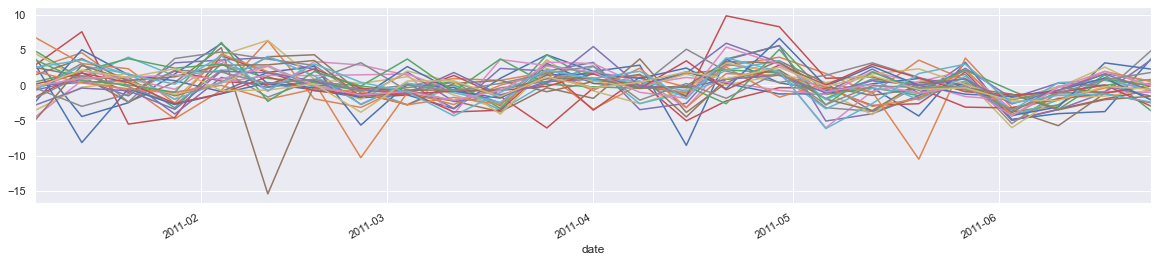

In [14]:
sns.set(rc={'figure.figsize':(20, 4)})

for stock in stock_list:
   data_by_stock[stock]['percent_change_price'].plot()

In [15]:
svr_pipeline = {}
for stock in stock_list:
    svr_pipeline[stock] = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', SVR(C=1.0, epsilon=0.2))])

In [16]:
merged_Y = pd.DataFrame(change_dict)
Y_final=merged_Y.idxmax(axis=1)

In [17]:
test_indexes = Y_final.sample(frac = 0.2,random_state=42).index

X_train={}
X_test={}
y_train={}
y_test ={}
finalY_train= Y_final.drop(test_indexes)
finalY_test= Y_final[test_indexes]
change_train = {}
change_test = {}

change_dict

for stock in stock_list:
    X_train[stock] = data_by_stock[stock].drop(test_indexes)
    X_test[stock] = data_by_stock[stock].loc[test_indexes,:]
    y_train[stock] =Y_dict[stock].drop(test_indexes)
    y_test[stock] = Y_dict[stock][test_indexes]
    change_train[stock] = change_dict[stock].drop(test_indexes)
    change_test[stock] = change_dict[stock][test_indexes]

In [18]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

distributions = dict(clf__C=uniform(loc=0, scale=4), clf__gamma=['scale','auto'], clf__epsilon=uniform(loc=0, scale=1))
#distributions = dict(clf__kernel=['rbf','poly'], clf__degree=[3,4,5], clf__C=uniform(loc=0, scale=4), clf__gamma=['scale','auto'], clf__epsilon=uniform(loc=0, scale=1))
search = {}
for stock in stock_list:
    clf = RandomizedSearchCV(svr_pipeline[stock], distributions, random_state=0,n_iter=200)
    search[stock] = clf.fit(X_train[stock], y_train[stock])
    svr_pipeline[stock].set_params(**search[stock].best_params_)

In [19]:
for stock in stock_list:
    svr_pipeline[stock].fit(X_train[stock],y_train[stock])

In [20]:
#from sklearn.model_selection import cross_val_score
r2_scores = {}
for stock in stock_list:
    r2_scores[stock] = cross_validate(svr_pipeline[stock], X_train[stock], y_train[stock])['test_score']
#r2_scores

In [21]:
avg_r2_scores = {}
for stock in stock_list:
    avg_r2_scores[stock] = np.average(r2_scores[stock])
#avg_r2_scores

In [22]:
np.average(list(avg_r2_scores.values()))

-5.522241988846082

In [23]:
predicted_stock_sell = {}
for stock in stock_list:
    predicted_stock_sell[stock]=svr_pipeline[stock].predict(X_train[stock])

In [24]:
predicted_stock_changes = {}
for stock in stock_list:
    predicted_stock_changes[stock] = 100*(predicted_stock_sell[stock]/X_train[stock]["next_weeks_open"]-1)
#predicted_stock_changes

In [25]:
stock_train_score = {}
for stock in stock_list:
    stock_train_score[stock]=mean_squared_error(change_train[stock],predicted_stock_changes[stock])
#stock_train_score

In [26]:
predicted_stock_changes_df = pd.DataFrame(predicted_stock_changes)
predicted_stock_changes_df['date'] = list(X_train.values())[0].index
predicted_stock_changes_df = predicted_stock_changes_df.set_index('date')
#predicted_stock_changes_df

In [27]:
#svc_pipeline = Pipeline([
#    ('preprocessor', preprocessor), 
#    ('clf', SVC(gamma="auto"))])

In [28]:
#svc_pipeline.fit(predicted_stock_changes_df, finalY_train)

In [29]:
pred = predicted_stock_changes_df.idxmax(axis=1)

In [30]:
predicted_stock_changes_df

AA       AXP        BA        BAC        CAT       CSCO  \
date                                                                        
2011-01-14  1.178218  1.812033  3.679121 -14.964646  10.589851 -15.352590   
2011-01-21  3.218358  1.767815  2.721927 -10.011710  12.318645 -13.809115   
2011-01-28  1.240750  6.195511  6.074151  -6.467313   8.322365 -14.179740   
2011-02-04 -5.477476  6.606185  2.851541 -11.624181   4.527222 -18.759926   
2011-02-11 -5.803603  0.956654  1.054555 -13.179882   0.550418  -4.659340   
2011-02-18 -3.529132  4.281440  1.543468 -10.825234  -0.696154  -4.099410   
2011-02-25 -2.553519  7.166885  1.375307 -10.137832   1.372676  -3.532866   
2011-03-11  2.700648  6.849245  3.227048 -10.074815   1.501133   0.854466   
2011-03-18  0.004600  4.724199  4.519966  -9.694849  -2.591195   3.588122   
2011-04-01 -5.965824  2.749570  0.117663  -4.303497  -8.457132   5.597769   
2011-04-08 -9.298154  1.087315 -0.249259  -5.012360  -5.353561   1.423944   
2011-04-15  0.126855  2.211732  1.027082   1.853307  -1.373354   6.411022   
2011-04-21 -3.301337 -0.690657 -2.705689   4.085482  -4.677762   6.096754   
2011-05-06 -4.541064 -6.384181 -7.322815   4.424523  -6.019844   2.465376   
2011-05-13 -3.642627 -5.171835 -6.602312   7.849717  -1.643513   6.790609   
2011-05-20  2.636300 -7.638788 -4.032060  11.798879   2.793695   9.458747   
2011-05-27 -2.087547 -8.807007 -5.568753   8.031435  -2.142644   8.271130   
2011-06-03  2.894180 -4.612092 -1.730291  14.698850   3.870337  11.983669   
2011-06-10  7.133770 -2.285073  0.556828  17.753273   7.428074  18.640558   
2011-06-24  7.626501 -3.353106  2.837021  21.894785   4.171687  20.228785   

                 CVX        DD       DIS         GE  ...       MRK      MSFT  \
date                                                 ...                       
2011-01-14  9.557804  7.248617  5.694295   5.850822  ...  0.121951 -7.830924   
2011-01-21  8.416327  9.661932  4.174473   0.805248  ...  0.357601 -7.370408   
2011-01-28  8.457694  5.922712  5.775515  -0.196294  ...  2.467854 -6.536508   
2011-02-04  4.630483  0.950665  1.212649  -3.271613  ...  3.556614 -6.637368   
2011-02-11  6.580180 -2.424247 -4.388143  -6.599321  ...  3.462386 -4.577898   
2011-02-18  2.573592 -3.329863 -3.584495  -3.781197  ...  4.157401 -3.081360   
2011-02-25 -0.485189 -2.028329 -4.010319  -4.102692  ...  5.936487 -2.754546   
2011-03-11  2.645975 -0.112373 -3.154876   0.653737  ...  4.958611  1.823506   
2011-03-18 -1.999086 -1.263494 -0.398550   2.085803  ...  6.299622  3.077092   
2011-04-01 -6.207382 -4.287856 -3.674455  -3.084969  ...  2.314183  1.983543   
2011-04-08 -7.250092 -4.201551 -1.114078  -0.738706  ...  1.281320 -0.898008   
2011-04-15 -3.016914 -2.136625  0.792680   1.621072  ... -0.258630  3.405624   
2011-04-21 -5.202804 -4.614401 -2.468680  -0.245849  ...  1.221213  1.544647   
2011-05-06 -1.420098 -3.312268 -4.675067   0.603335  ... -5.534343  0.600045   
2011-05-13 -0.241352  0.720971  0.084249   1.211516  ... -7.955886  3.985624   
2011-05-20  0.646444  2.647807  0.351789   3.988023  ... -6.976960  7.206988   
2011-05-27 -2.701702 -0.112373 -1.444485   2.085803  ... -6.261202  3.985624   
2011-06-03  0.875866  5.606839  5.397552   7.378332  ... -4.449443  8.597539   
2011-06-10  1.743052  6.176774  6.898165   9.724118  ... -2.621899  9.099671   
2011-06-24  3.924610  2.449836  9.768105  11.613811  ... -1.411709  7.118497   

                 PFE        PG         T       TRV       UTX        VZ  \
date                                                                     
2011-01-14  7.286737 -2.545117  4.383263  8.060825  6.601002  3.485762   
2011-01-21  7.403798 -2.914842  4.713357  7.041753  5.597502  4.969217   
2011-01-28  8.230436 -0.576327  8.684980  5.756715  3.832519  2.730816   
2011-02-04  2.164589  0.045567  6.547806  2.970731  2.267201  0.862983   
2011-02-11  4.607419 -1.266768  4.934583  0.310712 -0.242778  0.835205   
2011-02-18  4.274980  0.390932  5.231008 -2.

In [31]:
#pred = svc_pipeline.predict(predicted_stock_changes_df)
accuracy_score(finalY_train, pred)

0.15

In [32]:
def decision_score(best_stock_gt, best_stock_pred , stock_delta):
    pred_result = 0
    gt_result = 0
    for i in range(len(best_stock_pred)):
        pred_result += stock_delta[best_stock_pred[i]].iloc[i]
        gt_result += stock_delta[best_stock_gt[i]].iloc[i]
    return pred_result,gt_result
decision_score(finalY_train, pred , change_train)

(25.8660604, 88.984609)

In [33]:
predicted_stock_sell = {}
for stock in stock_list:
    predicted_stock_sell[stock]=svr_pipeline[stock].predict(X_test[stock])

In [34]:
predicted_stock_changes = {}
for stock in stock_list:
    predicted_stock_changes[stock] = 100*(predicted_stock_sell[stock]/X_test[stock]["next_weeks_open"]-1)
#predicted_stock_changes

In [35]:
predicted_stock_changes_df = pd.DataFrame(predicted_stock_changes)
predicted_stock_changes_df['date'] = list(X_test.values())[0].index
predicted_stock_changes_df = predicted_stock_changes_df.set_index('date')
#predicted_stock_changes_df

In [36]:
pred = predicted_stock_changes_df.idxmax(axis=1)

In [38]:
accuracy_score(finalY_test, pred)

0.0

In [39]:
decision_score(finalY_test, pred , change_test)

(-1.56337, 21.61075)